**Tensorflow instructions**
---
[https://www.tensorflow.org/tutorials/images/classification](https://www.tensorflow.org/tutorials/images/classification)

**Loading Dataset**
---


1.   After running, click on the accounts.google.com link
2.   Enter credentials and log in
3.   Authorize
4.   Copy authorization code
5.   Come back here and paste authorization code and hit Enter

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Import TensorFlow and other libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
# Define the pathway to the dataset
data_root = ("D:/Downloads/UCI Data Analytics/Class/Project_Final/fruits10")

In [18]:
# List data path with pathlib
import pathlib
data_dir = pathlib.Path(data_root)

In [19]:
# Count the number of images in the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13271


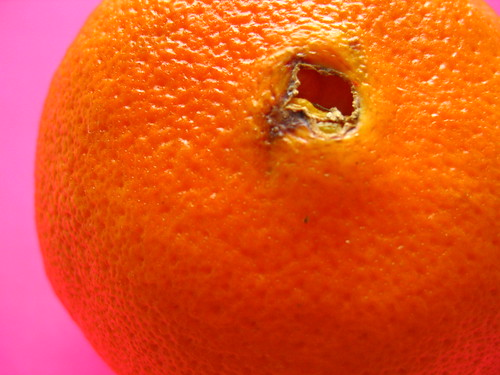

In [22]:
# Run some examples
orange = list(data_dir.glob('orange/*'))
PIL.Image.open(str(orange[0]))

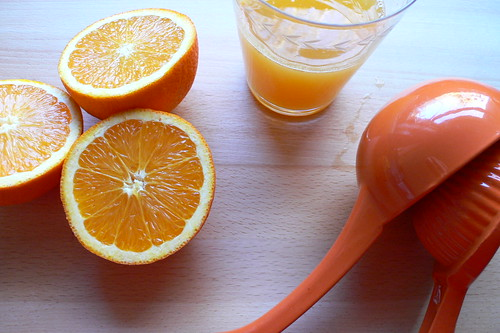

In [23]:
# Run anthoer example
PIL.Image.open(str(orange[1]))

**Load using keras.preprocessing**
---
Create a dataset

In [24]:
# Define parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [25]:
# Split training dataset to 80% and validation to 20%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13277 files belonging to 10 classes.
Using 10622 files for training.


In [26]:
# Define validation dataset to 20% of the images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13277 files belonging to 10 classes.
Using 2655 files for validation.


In [27]:
# List the class names
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'blueberry', 'fig', 'lemon', 'orange', 'peach', 'persimmon', 'tomato', 'watermelon']


**Visualizing the Data**

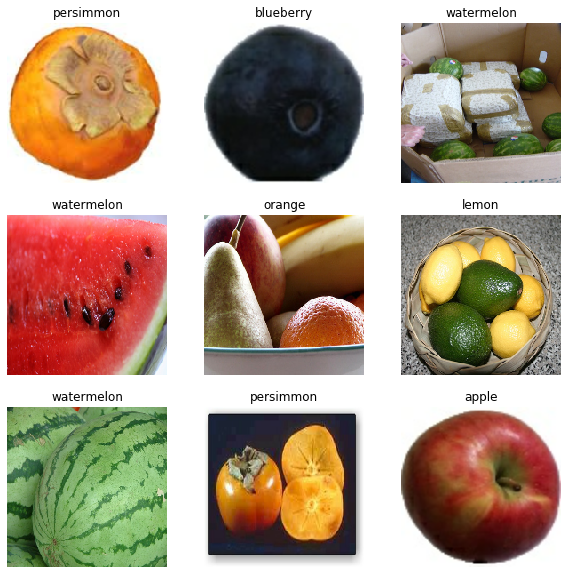

In [28]:
# Plot the first 9 images from the training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
# Manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Configure the dataset for performance**

In [30]:
# Cache the image for easier loading after first epoch
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

In [31]:
# Standardize the layer to [0,1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [32]:
# Apply to dataset by calling map (will take time)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


**Create the Model**

In [33]:
# List the number of classes (***change accordingly***)
num_classes = len(list(class_names))

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Data Augmentation**
---
[Experimental Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly)


In [34]:
# Generate additional training data from existing data for better accuracy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

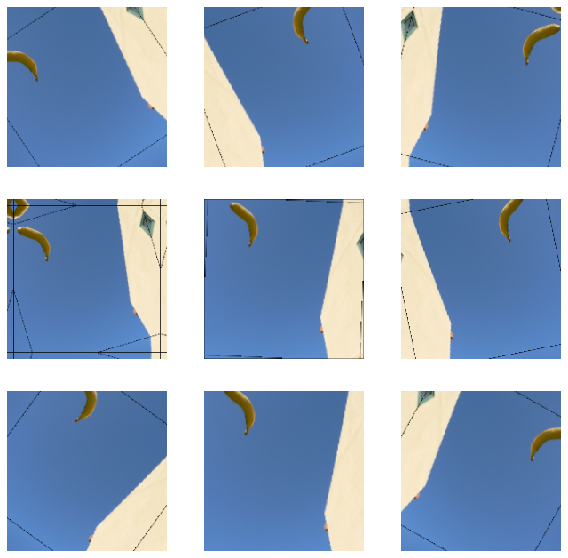

In [35]:
# Visualize some of the data from data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**
---
To regulate

In [36]:
# Create neural network
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile and Train**

In [37]:
# Compile the model using the "adam" optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
# List the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [39]:
# Run and train the model (takes a very long time)
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
332/332 [==============================] - 592s 2s/step - loss: 1.6873 - accuracy: 0.3963 - val_loss: 1.3802 - val_accuracy: 0.5055
Epoch 2/100
332/332 [==============================] - 491s 1s/step - loss: 1.3594 - accuracy: 0.5169 - val_loss: 1.2865 - val_accuracy: 0.5503
Epoch 3/100
332/332 [==============================] - 466s 1s/step - loss: 1.2628 - accuracy: 0.5542 - val_loss: 1.1955 - val_accuracy: 0.5687
Epoch 4/100
332/332 [==============================] - 616s 2s/step - loss: 1.2056 - accuracy: 0.5727 - val_loss: 1.1682 - val_accuracy: 0.5755
Epoch 5/100
332/332 [==============================] - 845s 3s/step - loss: 1.1511 - accuracy: 0.5950 - val_loss: 1.1397 - val_accuracy: 0.5879
Epoch 6/100
332/332 [==============================] - 1100s 3s/step - loss: 1.1230 - accuracy: 0.6052 - val_loss: 1.1428 - val_accuracy: 0.5872
Epoch 7/100
332/332 [==============================] - 880s 3s/step - loss: 1.0673 - accuracy: 0.6198 - val_loss: 1.1306 - val_accuracy

KeyboardInterrupt: 

**Visualize training results**

In [ ]:
# Plot the results of Training versus Validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Data Augmentation**
---
[Experimental Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly)


In [30]:
# Generate additional training data from existing data for better accuracy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

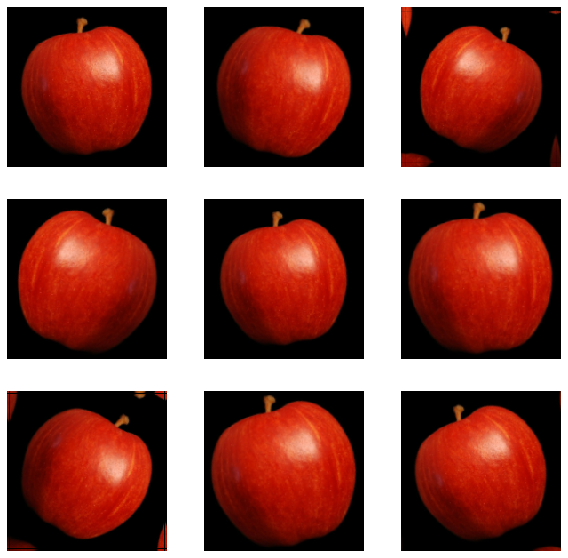

In [31]:
# Visualize some of the data from data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**
---
To regulate

In [32]:
# Create neural network
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile and Train**

In [33]:
# Compile the model using the "adam" optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
# List the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [36]:
# Run and train the model (takes a very long time)
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
332/332 [==============================] - 533s 2s/step - loss: 0.9022 - accuracy: 0.6796 - val_loss: 1.1163 - val_accuracy: 0.6275
Epoch 2/100
332/332 [==============================] - 554s 2s/step - loss: 0.8607 - accuracy: 0.6979 - val_loss: 1.1012 - val_accuracy: 0.6249
Epoch 3/100
332/332 [==============================] - 514s 2s/step - loss: 0.8435 - accuracy: 0.7019 - val_loss: 1.1415 - val_accuracy: 0.6185
Epoch 4/100
332/332 [==============================] - 520s 2s/step - loss: 0.8176 - accuracy: 0.7130 - val_loss: 1.1181 - val_accuracy: 0.6256
Epoch 5/100
332/332 [==============================] - 470s 1s/step - loss: 0.7718 - accuracy: 0.7313 - val_loss: 1.1668 - val_accuracy: 0.6121
Epoch 6/100
332/332 [==============================] - 520s 2s/step - loss: 0.7644 - accuracy: 0.7308 - val_loss: 1.1282 - val_accuracy: 0.6309
Epoch 7/100
332/332 [==============================] - 508s 2s/step - loss: 0.7289 - accuracy: 0.7362 - val_loss: 1.1280 - val_accuracy:

KeyboardInterrupt: 

**Predict on New Data**

In [28]:
# Test out by entering an image link for a fruit and changing the file name to the fruit
image_url = "http://bulknaturalfoods.com/wp-content/uploads/2012/03/Red-Delicious-2.jpg"
image_path = tf.keras.utils.get_file('apple', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

114688/112343 [==============================] - 0s 0us/step
This image most likely belongs to apple with a 99.61 percent confidence.


In [29]:
# Save the model
model.save("fruits_tensorflow-100-New10.h5")

In [20]:
my_model = keras.models.load_model('D:/Downloads/UCI Data Analytics/Class/Project_Final/fruits_tensorflow-100-New10-360.h5')

In [21]:
np.testing.assert_allclose(
    model.predict(train_ds), my_model.predict(train_ds)
)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 106030 / 106220 (99.8%)
Max absolute difference: 89.9314
Max relative difference: 52187.15
 x: array([[  2.622393,  -4.207327, -16.27005 , ...,   8.74913 ,   2.944783,
         -5.294258],
       [  1.142014,   1.243313, -10.453282, ...,   2.50631 ,  -7.143601,...
 y: array([[ 37.130318, -15.861313, -22.65688 , ...,  -5.579185, -19.265192,
        -22.315777],
       [  6.287859,  -0.856575,  -3.057719, ..., -18.49073 ,  -3.044468,...